Yichen Duan

Zihao Mao

Cameron Matson


11/20/2017

# Lab 7: CNNs

## Introduction

For this lab we examine the images of the Stanford Dog Dataset.  The dataset consits of ~20,000 images of dogs from 120 different breeds.

#### Issues
The dataset is primarily used for fine-grained classification problems, meaning that the instances are all members of the same main class and are divided by subclass.  In this case, the main class is 'Dog' and the subclass is the breed: 'Beagle', 'Poodle', 'Lab'...  These are potentially more difficult than standard classification problems because in theory all members of teh main class should at least share similar features.  In other words as the saying goes "a dog is a dog is a dog not a cat."

Another challenge with this dataset is that there is that they do not depict a standard scene.  These are not faces of dogs.  These are not photoshoot photos of dogs.  The images in the dataset are not even exclusively of dogs.  Some contain multiple dogs or even people.  The dataset would benefit from preprocessing in the form of some sort of standardization such that all the images are of the same kind, using facial detection for instance.

#### Uses
Some possible uses of this type of classification: maybe a city or some other community has had a problem recently with a particular breed of dog acting violently towards humans, this system could be used on video footage (from a source like street cameras) in an attempt to identify areas where these dogs are.  Another use could be by the American Kennel Club in order to help them identify dog breeds when registering dogs without previous paperwork.  Maybe the could use the system as a preliminary step to shrink down the number of applications.  Or maybe there is an online marketplace for person to person pet sales that wants to ensure that the sellers are reliably posting the breeds that the claim.

#### Metric
In both of the cases above a high level of accuracy would be required for it to replace a human classifier.  People, especially ones who work in Animal Control or for the AKC are likely to be pretty good at identifying dogs.  Therefore to make the system as useful as possible we'd like it to have as low a false negative rate as possible, this way the human user would only be tasked with identifying false positives.  Therefore we will use recall as our metric, specifically the micro-averaged recall, because we're particularly concerned with minimizing the number of false negatives for each class.

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
%matplotlib inline
# for zihao
imagedir = '../img_data/dogs/Images'
# for cameron
#imagedir = '../../data/dogs'

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import average 
from keras.models import Input, Model
from keras.regularizers import l2

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics as mt

import numpy as np

keras.__version__

'2.0.9'

## Data Preprocessing

There are 120 different breeds included in the dataset with bout 150 images of each breed for a total of 20,580 images.  The images are stored in directories by breed.  To make the size of the dataset more managable, we're only going to select 5 particular breeds.

In [9]:
# remove dsstore
for d in os.listdir(imagedir):
    if d.find('.DS') != -1:
        os.remove(os.path.join(imagedir,d))
        continue
    for f in os.listdir(os.path.join(imagedir, d)):
        if f.find('.DS') != -1:
            os.remove(os.path.join(imagedir,d,f))
    

In [10]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(imresize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [11]:
%%time
num_breeds = 5
h=128
w=128

dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 flat
1 Brittany_spaniel
2 Doberman
3 Pekinese
4 Welsh_springer_spaniel
753
Wall time: 5.61 s


In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)

enc = LabelEncoder()
y = enc.fit_transform(labels)

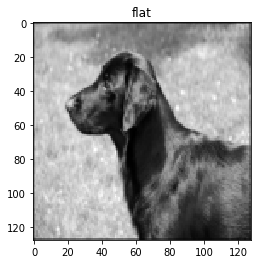

In [13]:
ex = dogs[0].reshape((h,w))
plt.imshow(ex, cmap='gray')
plt.title(labels[0])
plt.show()

Let's do a quick check of the distribution of breeds that we're using.

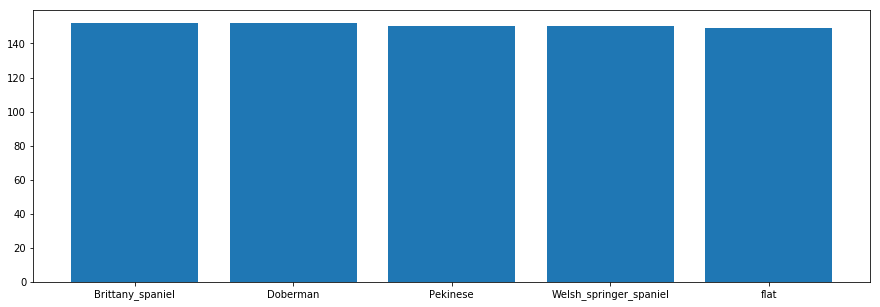

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(list(set(y)), pd.Series(y).value_counts())
plt.xticks(np.arange(5), enc.classes_)
plt.show()

As was stated previously the distribution betwewen classes is nearly uniform.

### Cross Validation Scheme

Since these networks take SOO long to train and we don't have that much data, we're  going to use a 3-fold cross-validation set up.  K-fold because we can't afford to not train on all of thee data, and 3 folds so we can finish on time.  We'll also use stratified folds to be safe even though our breed distribution is pretty uniform.  After we train the 3 models we'll be able to look at the average performance to get a sense of how the model might perform once deployed.

First we'll define 3 functions to perform three different architectures, a regular MLP, a basic CNN (a few convolutions followed by a few dense layers), and an Ensemble Net style architecture.

In [15]:
# some constants we'll need
img_hw = 128
img_wh = 128
l2_lambda = 0.001

NUM_CLASSES = 5

## MLP

In [16]:
def do_mlp(X_train, y_train, X_test, y_test):
    # make a 3 layer keras MLP
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(units=30, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    mlp.fit(X_train, y_train, 
            batch_size=32, epochs=100, 
            shuffle=True, verbose=1)
    
    yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
    
    return mlp, mt.recall_score(y_test,yhat_mlp, average='micro')

## cnn1: simple

In [17]:
def do_cnn1(X_train, y_train, X_test, y_test, y_test_ohe):
    cnn_layers = [32, 16]

    # make a CNN with conv layer and max pooling
    cnn = Sequential()
    cnn.add(Reshape((1, 128, 128), input_shape=(1,128*128)))

    for n in cnn_layers:
        cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1, h,w), data_format='channels_first'))
        cnn.add(Activation('relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    # add one layer on flattened output
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())

    cnn.add(Dropout(0.25))
    cnn.add(Dense(80))
    cnn.add(Activation('relu'))

    cnn.add(Dropout(0.50))
    cnn.add(Dense(20))
    cnn.add(Activation('relu'))


    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))


    # Let's train the model 
    cnn.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn.fit(np.expand_dims(X_train, axis = 1), y_train, 
            batch_size=32, epochs=100,
            validation_data=((np.expand_dims(X_test, axis=1), y_test_ohe)),
            shuffle=True, verbose=1)
    
    yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
    
    rec = mt.recall_score(y_pred=yhat_cnn, y_true=y_test, average='micro')
    return cnn, rec

## cnn2:  Ensemble Net

In [18]:
def do_ensemble(X_train, y_train, X_test, y_test):


    num_ensembles = 3

    input_holder = Input(shape=(img_wh, img_wh, 1))

    branches = []
    for _ in range(num_ensembles):

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(input_holder)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=32,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])
    X_train = np.expand_dims(X_train.reshape(-1,img_hw,img_hw), axis=3)
    X_test = np.expand_dims(X_test.reshape(-1,img_hw,img_hw), axis=3)
    # the flow method yields batches of images indefinitely, with the given transofmrations
    cnn_ens.fit(X_train, y_train, 
            batch_size=32, epochs=20,
            shuffle=True, verbose=1)
    yhat = np.argmax(cnn_ens.predict(X_test), axis=1)
    rec = mt.recall_score(y_test,yhat, average='micro')
    
    return cnn_ens, rec

And now for the loop...

In [19]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

N_SPLITS = 3

cnn1_rec = []
cnn2_rec = []
mlp_rec = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=False)
for i, (train, test) in enumerate(skf.split(X, y)):
    # split up the data
    X_train = X[train]
    y_train = y[train]
    
    X_test = X[test]
    y_test = y[test]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    # architecture 1
    print('\ntraining fold', i+1, 'cnn 1')
    cnn1, cnn1_result = do_cnn1(X_train, y_train_ohe, X_test, y_test, y_test_ohe)
    cnn1_rec.append(cnn1_result)
    print('fold', i+1, 'cnn1 recall score: ', cnn1_result)
    
    # architecture 2
    print('\ntraining fold', i+1, 'cnn 2')
    cnn2, cnn2_result = do_ensemble(X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train_ohe)
    cnn2_rec.append(cnn2_result)
    print('fold', i+1, 'cnn2 recall score: ', cnn2_result)
        
    # MLP
    print('\ntraining fold', i+1, 'mlp')
    mlp, mlp_result = do_mlp(X_train, y_train_ohe, X_test, y_test)
    mlp_rec.append(mlp_result)
    print('fold', i+1, 'mlp recall score: ', mlp_result)



training fold 1 cnn 1
Train on 501 samples, validate on 252 samples
Epoch 1/100
501/501 [==============================] - 19s 38ms/step - loss: 0.1646 - acc: 0.2196 - val_loss: 0.1586 - val_acc: 0.2063
Epoch 2/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1562 - acc: 0.2874 - val_loss: 0.1534 - val_acc: 0.3135
Epoch 3/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1514 - acc: 0.3194 - val_loss: 0.1524 - val_acc: 0.2817
Epoch 4/100
501/501 [==============================] - 19s 37ms/step - loss: 0.1474 - acc: 0.3792 - val_loss: 0.1501 - val_acc: 0.3452
Epoch 5/100
501/501 [==============================] - 19s 37ms/step - loss: 0.1444 - acc: 0.3852 - val_loss: 0.1476 - val_acc: 0.3611
Epoch 6/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1409 - acc: 0.4052 - val_loss: 0.1466 - val_acc: 0.3690
Epoch 7/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1329 - acc: 0.4451 - val_loss: 0.1488 - va

Epoch 61/100
501/501 [==============================] - 18s 37ms/step - loss: 0.0082 - acc: 0.9741 - val_loss: 0.1929 - val_acc: 0.4048
Epoch 62/100
501/501 [==============================] - 18s 37ms/step - loss: 0.0065 - acc: 0.9800 - val_loss: 0.2007 - val_acc: 0.3968
Epoch 63/100
501/501 [==============================] - 18s 37ms/step - loss: 0.0072 - acc: 0.9800 - val_loss: 0.1994 - val_acc: 0.4127
Epoch 64/100
501/501 [==============================] - 18s 37ms/step - loss: 0.0068 - acc: 0.9800 - val_loss: 0.1919 - val_acc: 0.4246
Epoch 65/100
501/501 [==============================] - 18s 36ms/step - loss: 0.0067 - acc: 0.9820 - val_loss: 0.1950 - val_acc: 0.4405
Epoch 66/100
501/501 [==============================] - 18s 37ms/step - loss: 0.0055 - acc: 0.9800 - val_loss: 0.1979 - val_acc: 0.3889
Epoch 67/100
501/501 [==============================] - 18s 36ms/step - loss: 0.0047 - acc: 0.9860 - val_loss: 0.1988 - val_acc: 0.4008
Epoch 68/100
501/501 [==========================

Epoch 7/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1334 - acc: 0.4591 - val_loss: 0.1370 - val_acc: 0.4167
Epoch 8/100
501/501 [==============================] - 19s 37ms/step - loss: 0.1250 - acc: 0.5110 - val_loss: 0.1329 - val_acc: 0.4246
Epoch 9/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1202 - acc: 0.5369 - val_loss: 0.1351 - val_acc: 0.4246
Epoch 10/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1074 - acc: 0.6088 - val_loss: 0.1451 - val_acc: 0.3651
Epoch 11/100
501/501 [==============================] - 18s 37ms/step - loss: 0.1004 - acc: 0.6387 - val_loss: 0.1410 - val_acc: 0.4048
Epoch 12/100
501/501 [==============================] - 18s 36ms/step - loss: 0.0982 - acc: 0.6447 - val_loss: 0.1416 - val_acc: 0.4325
Epoch 13/100
501/501 [==============================] - 18s 36ms/step - loss: 0.0852 - acc: 0.7186 - val_loss: 0.1423 - val_acc: 0.4286
Epoch 14/100
501/501 [=============================

501/501 [==============================] - 0s 274us/step - loss: 0.1310 - acc: 0.4291
Epoch 37/100
501/501 [==============================] - 0s 272us/step - loss: 0.1361 - acc: 0.4192
Epoch 38/100
501/501 [==============================] - 0s 277us/step - loss: 0.1322 - acc: 0.4371
Epoch 39/100
501/501 [==============================] - 0s 272us/step - loss: 0.1295 - acc: 0.4371
Epoch 40/100
501/501 [==============================] - 0s 268us/step - loss: 0.1312 - acc: 0.4411
Epoch 41/100
501/501 [==============================] - 0s 263us/step - loss: 0.1317 - acc: 0.4092
Epoch 42/100
501/501 [==============================] - 0s 268us/step - loss: 0.1325 - acc: 0.4371
Epoch 43/100
501/501 [==============================] - 0s 270us/step - loss: 0.1281 - acc: 0.4511
Epoch 44/100
501/501 [==============================] - 0s 266us/step - loss: 0.1265 - acc: 0.4491
Epoch 45/100
501/501 [==============================] - 0s 264us/step - loss: 0.1278 - acc: 0.4531
Epoch 46/100
501/501 [=

504/504 [==============================] - 19s 37ms/step - loss: 0.0060 - acc: 0.9762 - val_loss: 0.2034 - val_acc: 0.3936
Epoch 74/100
504/504 [==============================] - 19s 38ms/step - loss: 0.0042 - acc: 0.9841 - val_loss: 0.1926 - val_acc: 0.4378
Epoch 75/100
504/504 [==============================] - 19s 37ms/step - loss: 0.0071 - acc: 0.9782 - val_loss: 0.2058 - val_acc: 0.3855
Epoch 76/100
504/504 [==============================] - 18s 36ms/step - loss: 0.0119 - acc: 0.9643 - val_loss: 0.2046 - val_acc: 0.3855
Epoch 77/100
504/504 [==============================] - 18s 36ms/step - loss: 0.0049 - acc: 0.9861 - val_loss: 0.2101 - val_acc: 0.3695
Epoch 78/100
504/504 [==============================] - 19s 37ms/step - loss: 0.0037 - acc: 0.9881 - val_loss: 0.2114 - val_acc: 0.3534
Epoch 79/100
504/504 [==============================] - 19s 38ms/step - loss: 0.0064 - acc: 0.9841 - val_loss: 0.2134 - val_acc: 0.3534
Epoch 80/100
504/504 [==============================] - 19s 3

## so how did it do....

Below are the general statistics from the cross validation

In [20]:
print('stats:')
print('*'*6)
print('mlp:', np.mean(mlp_rec), '+-', np.std(mlp_rec))
print('cnn1:', np.mean(cnn1_rec), '+-', np.std(cnn1_rec))
#print('cnn2:', np.mean(cnn2_rec), '+-', np.std(cnn2_rec))

stats:
******
mlp: 0.371852489322 +- 0.0210923885152
cnn1: 0.402291706509 +- 0.0193048739522


We can also look at the confusion matrix for the final instance of each of the architecture's

In [21]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    if cnn1 is not None:
        yhat_cnn1 = np.argmax(cnn1.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn1 = mt.recall_score(y_test,yhat_cnn1, average='micro')
        plt.subplot(1,3,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN1: '+str(rec_cnn1))
    
    if cnn2 is not None:
        yhat_cnn2 = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn2 = mt.recall_score(y_test,yhat_cnn2, average='micro')
        plt.subplot(1,3,2)
        cm = mt.confusion_matrix(y_test,yhat_cnn2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN2: '+str(rec_cnn2))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        rec_mlp = mt.recall_score(y_test,yhat_mlp, average='micro')
        plt.subplot(1,3,3)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(rec_mlp))

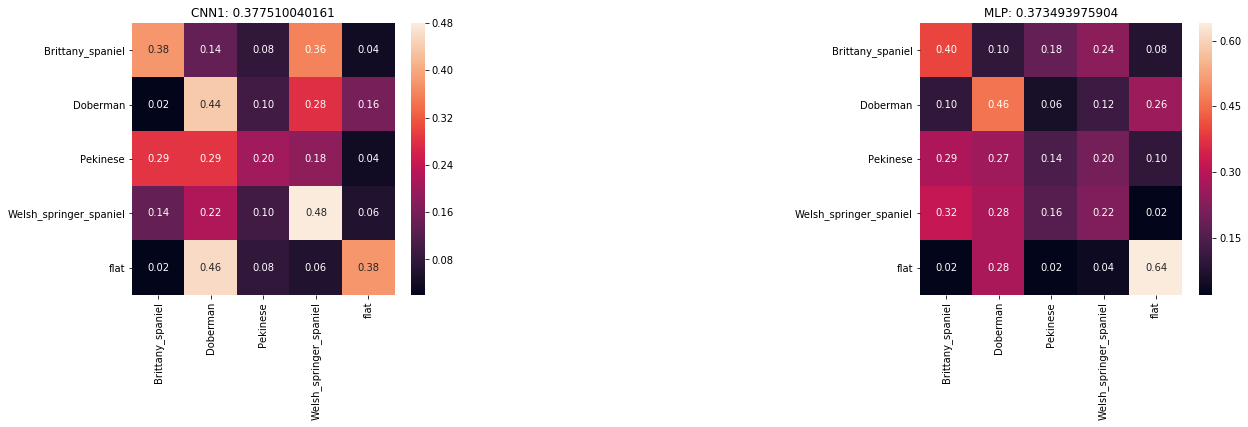

In [22]:
compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc)
#compare_mlp_cnn(cnn1, None, mlp, X_test, y_test, enc)

We can also look at the ROC curve for each architecture.  Again, we'll just use the last fold, but assuming that the standard deviation on the cross-validation is small it should give a fairly good estimation. 

150/150 [==============================] - 3s 17ms/step


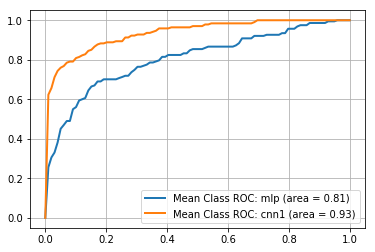

In [23]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

perclass_mean_tpr = 0.0
roc_auc = 0

# we'll just grab a random 20 % of the samples
idx = np.random.randint(0, len(X), size=int(len(X)/5))
X_hm = X[idx]
y_hm = y[idx]

probas_mlp = mlp.predict_proba(X_hm)
probas_cnn1 = cnn1.predict_proba(np.expand_dims(X_hm, axis=1))
#probas_cnn2 = cnn2.predict_proba(np.expand_dims(X_hm, axis=1))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for arch in ['mlp', 'cnn1', 'cnn2']:
#for arch in ['mlp', 'cnn1']:
    probas = eval('probas_'+arch)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_test)
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_hm,
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,lw=2,label = 'Mean Class ROC: %s (area = %0.2f)'
                   % (arch, roc_auc))
    
plt.legend(loc='best')
plt.grid()

## With more data

Now we'll use the ImageDataGenerator from keras to expand our dataset to see if we can improve the general performance of the simple cnn model.  The datagenerator will add random noise to the images and expand the size of our 

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [30]:
# we need to redefine our train and test splits
X = X.reshape(-1,img_hw,img_hw)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

In [31]:
# the datagenerator does the reshaping for us so we need to redefine the cnn model
cnn = Sequential()

# no reshape here!

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

In [38]:
# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(np.expand_dims(X_train, axis = 3), y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=10, verbose=1,
                  validation_data=(np.expand_dims(X_test, axis = 3),y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/10
4/4 [==============================] - 5s 1s/step - loss: 1.7202 - acc: 0.3446 - val_loss: 1.6087 - val_acc: 0.4636
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 1.6679 - acc: 0.4121 - val_loss: 1.5712 - val_acc: 0.4967
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 1.6087 - acc: 0.4106 - val_loss: 1.5034 - val_acc: 0.4834
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 1.6290 - acc: 0.4004 - val_loss: 1.5533 - val_acc: 0.4437
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 1.5942 - acc: 0.4127 - val_loss: 1.6339 - val_acc: 0.4238


In [39]:
# finally we also need to redefine the viz function
def compare_mlp_cnn(cnn1, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    if cnn1 is not None:
        yhat_cnn1 = np.argmax(cnn1.predict( np.expand_dims(X_test.reshape(-1, img_hw,img_hw), axis=3)), axis=1)
        rec_cnn1 = mt.recall_score(y_test,yhat_cnn1, average='micro')
        plt.subplot(1,3,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN1: '+str(rec_cnn1))

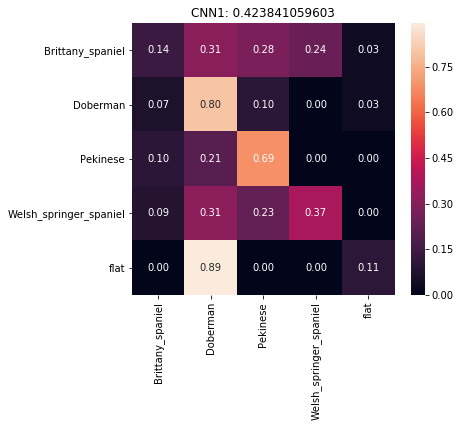

In [40]:
compare_mlp_cnn(cnn, X_test, y_test, enc)